# Benchmark and Comparisons

In [2]:
%reload_ext autoreload
%autoreload 1
%aimport train.cnn_train, model.improved_tumor_cnn, model.tumor_efficientnet, model.tumor_vit, common

import os
import torch
import pandas as pd
from typing import List
from matplotlib import pyplot as plt

from train.cnn_train import validate
from model.improved_tumor_cnn import build_model as build_cnn
from model.tumor_efficientnet import build_model as build_efficientnet
from model.tumor_vit import build_vit_model as build_vit
from common import DEVICE

## Load the Models

In [3]:
base_path = "open_weights"

model_specs = {
    "brain_tumor_mri_CNN_0000": (build_cnn, (512, 512)),
    "brain_tumor_mri_EfficientNet_0000": (build_efficientnet, (150, 150)),
    "brain_tumor_mri_EfficientNet_0001": (build_efficientnet, (256, 256)),
    "brain_tumor_mri_ViT_0000": (build_vit, (150, 150)),
}

# Generate paths to the weights files
weights_paths = {
    name: os.path.join(base_path, name, "weights.pth")
    for name in model_specs
}
history_paths = {
    name: os.path.join(base_path, name, "history.csv")
    for name in model_specs
}

In [4]:
def load_model(model_class, weights_path, img_size):
    model = model_class(num_classes=4, img_size=img_size, device=DEVICE)
    model.load_state_dict(torch.load(weights_path))
    model.eval()
    return model

models = {}
for name, (model_class, img_size) in model_specs.items():
    print(f"Loading {name}...")
    weight_path = weights_paths[name]
    loaded_model = load_model(model_class, weight_path, img_size)
    models[name] = loaded_model

histories = {name: pd.read_csv(path) for name, path in history_paths.items()}

Loading brain_tumor_mri_CNN_0000...
Loading brain_tumor_mri_EfficientNet_0000...
Loading brain_tumor_mri_EfficientNet_0001...
Loading brain_tumor_mri_ViT_0000...


## Compare them on the original Dataset train/validation

Evaluating brain_tumor_mri_CNN_0000...
Train Loss: 0.5217


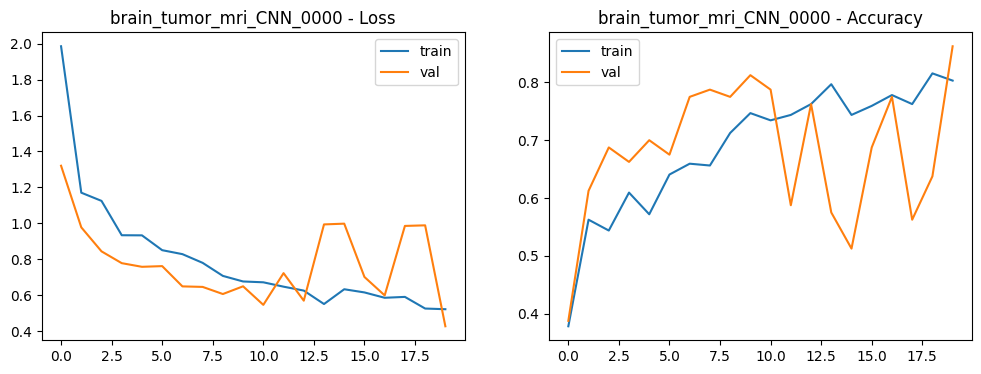

..
brain_tumor_mri_CNN_0000 - Test Loss: 2.4021
brain_tumor_mri_CNN_0000 - Test Accuracy: 0.3905
Evaluating brain_tumor_mri_EfficientNet_0000...
Train Loss: 0.0177


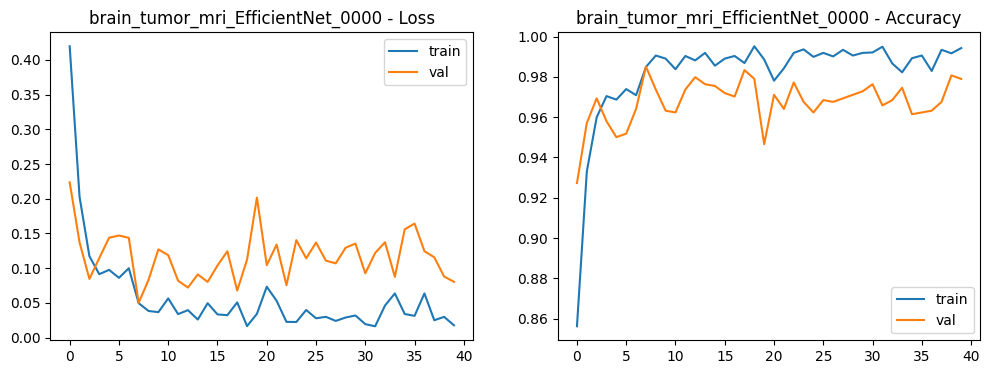

..
brain_tumor_mri_EfficientNet_0000 - Test Loss: 0.1019
brain_tumor_mri_EfficientNet_0000 - Test Accuracy: 0.9733
Evaluating brain_tumor_mri_EfficientNet_0001...
Train Loss: 0.0283


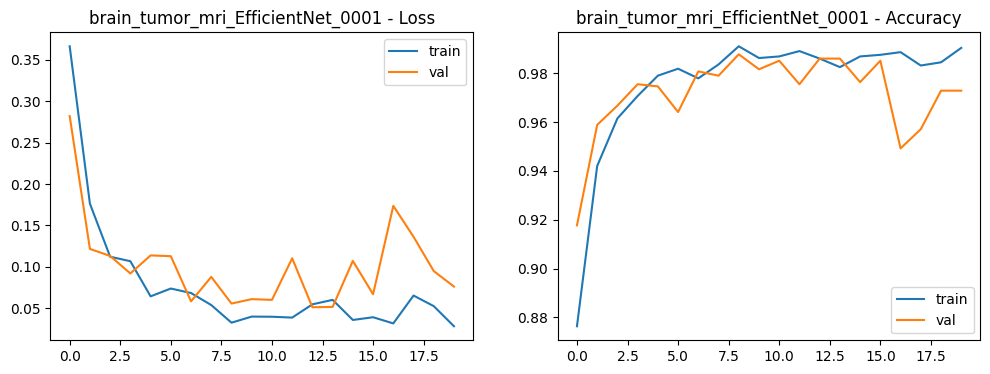

..
brain_tumor_mri_EfficientNet_0001 - Test Loss: 0.1164
brain_tumor_mri_EfficientNet_0001 - Test Accuracy: 0.9664
Evaluating brain_tumor_mri_ViT_0000...
Train Loss: 0.2848


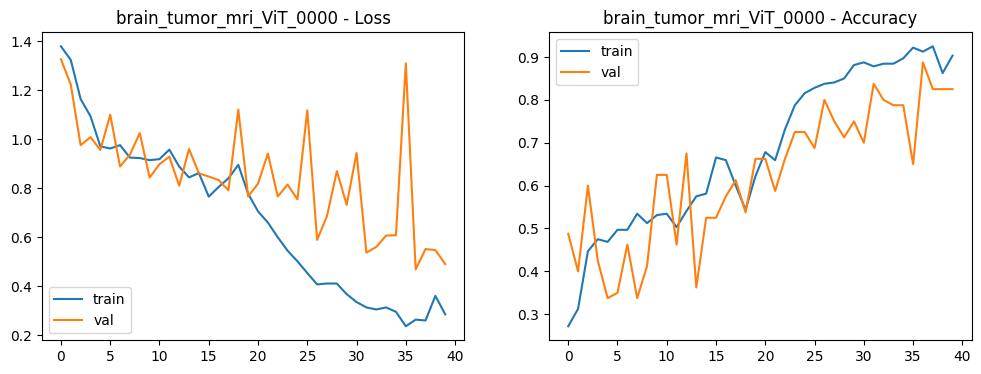

..
brain_tumor_mri_ViT_0000 - Test Loss: 2.9169
brain_tumor_mri_ViT_0000 - Test Accuracy: 0.5500


In [5]:
from torch import nn
from torch.utils.data import DataLoader
from data_loader import create_data_loaders

# Plot training history
def plot_history(history: pd.DataFrame) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history["train_loss"], label="train")
    axes[0].plot(history["val_loss"], label="val")
    axes[0].set_title(f"{name} - Loss")
    axes[0].legend()
    axes[1].plot(history["train_acc"], label="train")
    axes[1].plot(history["val_acc"], label="val")
    axes[1].set_title(f"{name} - Accuracy")
    axes[1].legend()
    plt.show()
# Evaluate on test set
def test_evaluate(model: nn.Module, loader: DataLoader) -> None:
    loss, acc = validate(model, loader, nn.CrossEntropyLoss())
    print(f"{name} - Test Loss: {loss:.4f}\n{name} - Test Accuracy: {acc:.4f}")

for name, model in models.items():
    print(f"Evaluating {name}...")

    train_loader, val_loader, test_loader = create_data_loaders(img_size=model_specs[name][1])
    history = histories[name]
    
    print(f"Train Loss: {history['train_loss'].iloc[-1]:.4f}")

    plot_history(history)
    print(f"..")
    test_evaluate(model, test_loader)

## Compare them on a similar Train/Validation dataset

In [5]:

from torch import nn
from torch.utils.data import DataLoader
from common import TEST_DIR_2, TRAIN_DIR_2
from data_loader import create_data_loaders

for name, model in models.items():
    print(f"Evaluating {name}...")

    train_loader, val_loader, test_loader = create_data_loaders(
        img_size=model_specs[name][1],
        train_dir=TRAIN_DIR_2,
        test_dir=TEST_DIR_2
        )

    test_evaluate(model, test_loader)

Evaluating brain_tumor_mri_CNN_0000...
brain_tumor_mri_CNN_0000 - Test Loss: 4.4039
brain_tumor_mri_CNN_0000 - Test Accuracy: 0.2157
Evaluating brain_tumor_mri_EfficientNet_0000...
brain_tumor_mri_EfficientNet_0000 - Test Loss: 1.4960
brain_tumor_mri_EfficientNet_0000 - Test Accuracy: 0.7589
Evaluating brain_tumor_mri_EfficientNet_0001...
brain_tumor_mri_EfficientNet_0001 - Test Loss: 1.6221
brain_tumor_mri_EfficientNet_0001 - Test Accuracy: 0.7437
Evaluating brain_tumor_mri_ViT_0000...
brain_tumor_mri_ViT_0000 - Test Loss: 5.2470
brain_tumor_mri_ViT_0000 - Test Accuracy: 0.3350


## Compare them on a Tumor Dataset

In [6]:
import os
import torch
from typing import Tuple, Dict
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from common import DATA_DIR_3, DEVICE, CLASS_NAMES, BATCH_SIZE

DATA_DIR_3_IMAGES = os.path.join(DATA_DIR_3, "Brain Tumor Data Set", "Brain Tumor Data Set")

In [7]:
def create_dataset3_loader(
    img_size: Tuple[int, int],
    batch_size: int = BATCH_SIZE
) -> DataLoader:
    """Create DataLoader for the third dataset with 2 classes."""
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(root=DATA_DIR_3_IMAGES, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [8]:
ORIGINAL_TO_NEW: Dict[int, int] = {
    # Original 4-class indices to 2-class mapping
    0: 0,  # glioma -> Brain Tumor
    1: 0,  # meningioma -> Brain Tumor
    2: 1,  # notumor -> Healthy
    3: 0   # pituitary -> Brain Tumor
}

def evaluate_binary(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device = DEVICE
) -> float:
    """Evaluate a 4-class model on binary classification task."""
    model.eval()
    correct = 0
    total = 0
    
    # Create tensor for efficient remapping
    remap_tensor = torch.tensor(
        [ORIGINAL_TO_NEW[i] for i in range(len(CLASS_NAMES))],
        device=device
    )
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Remap predictions to binary classes
            remapped_preds = remap_tensor[preds]
            
            correct += (remapped_preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

In [9]:
for model_name, model in models.items():
        img_size = model_specs[model_name][1]  # Get original img_size for the model
        loader = create_dataset3_loader(img_size)
        accuracy = evaluate_binary(model, loader)
        print(f"{model_name} accuracy on Dataset 3: {accuracy:.2%}")

brain_tumor_mri_CNN_0000 accuracy on Dataset 3: 45.24%
brain_tumor_mri_EfficientNet_0000 accuracy on Dataset 3: 54.54%
brain_tumor_mri_EfficientNet_0001 accuracy on Dataset 3: 42.59%
brain_tumor_mri_ViT_0000 accuracy on Dataset 3: 50.09%
